- https://arxiv.org/pdf/1811.03575.pdf

In [2]:
import keras
import keras.backend as K


# this is really an abuse of the keras API but it's the
# simplest way to do this
class KLRegularizer(keras.regularizers.Regularizer):
    def __init__(self, include_prior_loss=False):
        self.layers = []

    def __call__(self, X):
        self.layers.append(X)
        return 0.

    @property
    def penalty(self):
        layers = K.stack(self.layers, axis=0)
        layer_dims = K.cast_to_floatx(K.int_shape(layers[0]))
        n_w = layer_dims[0]
        n_h = layer_dims[1]
        n_o = layer_dims[3]
        mu_i = K.mean(layers, axis=0)
        var_q_i = K.var(layers, axis=0)
        kl_i = K.log(var_q_i) + (var_p_i / var_q_i) + (mu_i**2 / var_q_i)
        if include_prior_loss:
            var_p_i = 2 / (n_w * n_h * n_o)
            kl_i = 0.5 * kl_i - K.log(var_p_i)
        return K.sum(kl_i)


class EnsembleLoss:
    def __init__(self, kl_regularizers=None, beta=10**-5):
        if kl_regularizers is None:
            kl_regularizers = []
        self.kl_regularizers = kl_regularizers
        self.beta = beta
        
    def __call__(self, y_true, y_pred):
        entropy = self.entropy(y_true, y_pred)
        # this is notationally wrong and computationally inefficient
        # but it seems to be the best way to work with how keras handles
        # loss.
        for regularization in self.kl_regularizers:
            entropy += self.beta * regularization.penalty
        return entropy

    def entropy(self, y_true, y_pred):
        ensemble_entropy = K.categorical_crossentropy(y_true, y_pred, axis=-1)
        return K.sum(ensemble_entropy, axis=-1)

Using TensorFlow backend.


In [3]:
N_MODELS = 5

main_input = keras.layers.Input(shape=(28, 28, 1))


# need to stack all outputs into a single layer because keras expects
# n_outputs = len(y_train)
class Stack(keras.layers.Layer):
    def call(self, X):
        return K.stack(X, axis=1)
    
    def compute_output_shape(self, input_shape):
        # assumes all input shapes are the same
        return (input_shape[0][0], len(input_shape), input_shape[0][1])

kl_reg1 = KLRegularizer()
kl_reg2 = KLRegularizer()

def make_layers(input_):
    # from
    # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                            kernel_regularizer=kl_reg1,
                            kernel_initializer='he_normal')(input_)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                            kernel_regularizer=kl_reg2,
                            kernel_initializer='he_normal')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(10, activation='softmax')(x)
    return x

layers = [make_layers(main_input) for _ in range(N_MODELS)]
ensemble_output = Stack()(layers)
ensemble = keras.models.Model(inputs=main_input, outputs=ensemble_output)

In [4]:
ensemble.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 26, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (

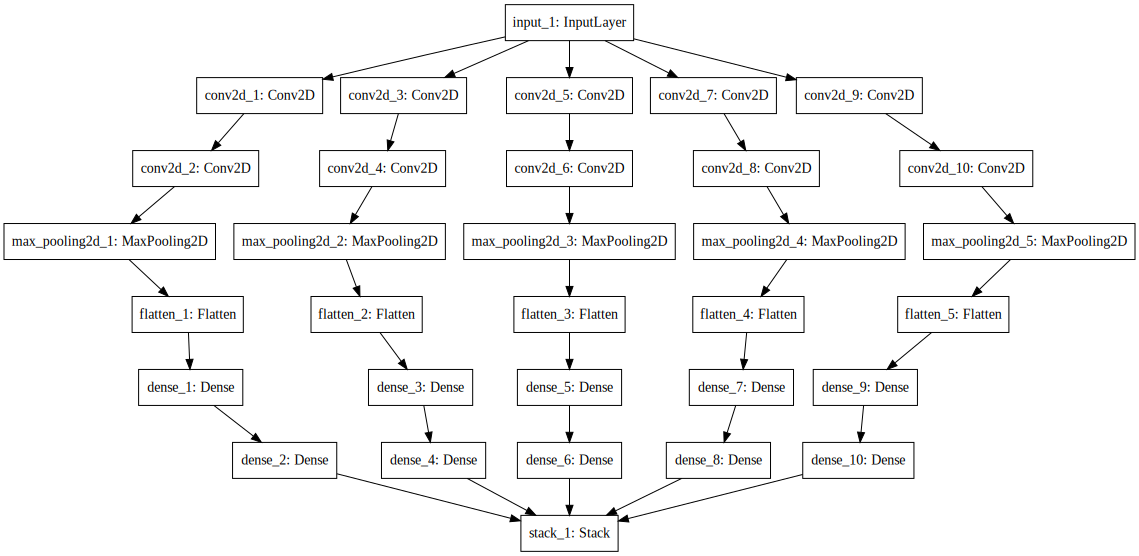

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(ensemble).create(prog='dot', format='svg'))

In [6]:
loss = EnsembleLoss([kl_reg1, kl_reg2])
ensemble.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

In [7]:
from keras.datasets.mnist import load_data
import numpy as np
from unittest import mock

(X_train, y_train), (X_test, y_test) = load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_train = keras.utils.to_categorical(y_train, 10)
y_train = y_train[:, np.newaxis, :]
y_test = keras.utils.to_categorical(y_test, 10)
y_test = y_test[:, np.newaxis, :]

In [8]:
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 1, 10))

In [9]:
ensemble.fit(
    X_train, y_train,
    batch_size=256,
    validation_data=(X_test, y_test),
    epochs=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
 4096/60000 [=>............................] - ETA: 7:19 - loss: 5.7543 - acc: 0.6651

KeyboardInterrupt: 

In [ ]:
p = ensemble.predict(X_test)
p.shape

In [ ]:
p

In [ ]:
p_mean = p.mean(axis=1)
p_mean.shape

In [ ]:
p_mean

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(
    np.argmax(y_test.reshape(-1, 10), axis=1),
    np.argmax(p_mean, axis=1))

In [ ]:
for r in loss.kl_regularizers:
    print(K.eval(r.penalty))